In [1]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Georgia';
font-size:1.2em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
color: #256178;
}
</style>
""")


In [2]:
import pylab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the data into a dataframe 

<b> Reading data from the required CSV files. </b>

In [3]:
flow = pd.read_csv("flow.tsv", na_values=['-'], delimiter="\t", error_bad_lines=False)
occupancy = pd.read_csv("occupancy.tsv", na_values=['-'], delimiter="\t", error_bad_lines=False)
speed = pd.read_csv("speed.tsv", na_values=['-'], delimiter="\t", error_bad_lines=False)
timestamp = pd.read_csv("timestamp.tsv", na_values=['-'], delimiter="\t", error_bad_lines=False)

<b> Concating the values of the columns into a single dataframe </b>

In [4]:
df = pd.concat([flow,occupancy,speed,timestamp], axis=1)

In [5]:
df.columns = ['flow1','flow2','flow3','occupancy1','occupancy2','occupancy3','speed1','speed2','speed3','timestamp']
df.head()

,flow1,flow2,flow3,occupancy1,occupancy2,occupancy3,speed1,speed2,speed3,timestamp
0,9,4,255,4.0,2.0,4.0,67.0,60.0,0.0,2006-09-01T00:01:07
1,11,10,255,4.0,5.0,4.0,66.0,64.0,0.0,2006-09-01T00:02:07
2,-8,3,255,3.0,1.0,4.0,71.0,63.0,0.0,2006-09-01T00:03:07
3,5,9,255,2.0,3.0,4.0,65.0,70.0,0.0,2006-09-01T00:04:07
4,7,10,255,2.0,4.0,4.0,66.0,64.0,0.0,2006-09-01T00:05:08


<b> Implementing vector seperation. Dividing the single dataframe into seperate dataframes. </b>

In [6]:
df1 =  pd.DataFrame({"flow" : df.flow1, "occupancy" : df.occupancy1,"speed" : df.speed1,"timestamp" : df.timestamp,"detector" : "x"})
df2 = pd.DataFrame({"flow" : df.flow2, "occupancy" : df.occupancy2,"speed" : df.speed2,"timestamp" : df.timestamp,"detector" : "y"})
df3 = pd.DataFrame({"flow" : df.flow3, "occupancy" : df.occupancy3,"speed" : df.speed3,"timestamp" : df.timestamp,"detector" : "z"})

<b> Concatenating the dataframes </b>

In [7]:
frames = [df1, df2, df3]
result = pd.concat(frames)

<b> Sorting on timestamp </b>

In [8]:
result = result.sort_values("timestamp")

 # Cleaning the data

# Flow Outlier Visualization

In the below cell we plot the unique values of flow to visulaize possible outliers. 

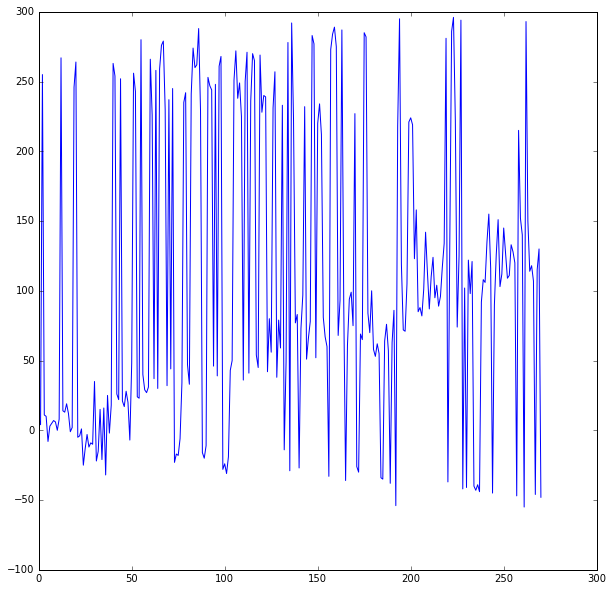

In [9]:
plt.figure(figsize=(10,10))
plt.plot(result["flow"].unique())

       
# Occupancy Outlier Visualization
<b>Finding outlier values and cleaning the occupancy column </b>
 
 <b>Observations :- </b>
        As we can see from the graph below, the occupancy values in the dataset increase consistently over a range
       of 0 to 100 but change drastically after that. This indicates possible outliers and wrong data.From the above
       observation, we conclude that even during a traffic jam the occupancy values should not be
       greater than a threshold of 120. So, we keep a variable jam_occupancy_threshold which holds a value of 120.
       This value helps us in identifying values which can be ignored while computing probablity distribution. We 
       can safely assume a probability density of 0 for rows carying such values. 

    

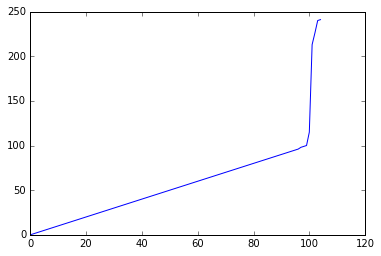

In [10]:
val = np.sort(result["occupancy"].unique())
plt.plot(val)

# Speed Outlier Visualization
<b>Finding outlier values and cleaning the Speed column </b>
 
Observations :- The graph below shows that the data is consistent till value 120 and gets skwed above that i.e speed > 120 mph. This makes perfect sense as speeds above are not practically feasible considering the speed limit laws.



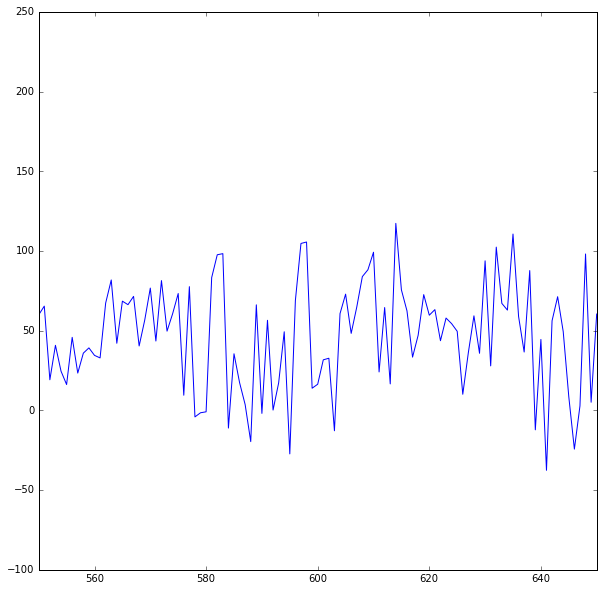

In [11]:
plt.figure(figsize=(10,10))
plt.xlim(550, 650)
plt.plot(result["speed"].unique())

# Removing Wrong Data

<b> There are several rows which can be easily identified as wrong values. We will be identifying these values below and will work on removing this data </b>

<b> Observation :- </b> 

In the below cell we try to remove all rows where speed is less than 0 or the flow is less than zero. This is practically infeasible 

In [12]:
removeResult1 = result[(result['speed'] < 0) | (result['flow'] < 0)]

In the below cell we try to remove all rows where flow is equal to zero and speed is greater than zero. This is also practically not possible

In [13]:
removeResult2 = result[(result['flow'] == 0) & (result['speed'] > 0)]

In the below cell we work on defining the Jam occupancy threshold which we had earlier defined while checking occupancy outliers 

In [14]:
jam_occupancy_threshold = 120
removeResult3 = result[((result['speed'] == 0) & 
                            (result['flow'] == 0) & 
                            (result['occupancy'] != 0) & 
                            (result['occupancy'] < jam_occupancy_threshold))]

In the below cell we work on removing rows which have a speed of zero and an occupancy of zero but the flow is greater than zero. This is not possible practically

In [15]:
removeResult5 = result[(result['speed'] == 0) & (result['flow'] != 0) & (result["occupancy"] == 0)]

In the below cell we remove all the rows which contain a null value in any of the column. 

In [16]:
removeResult6 = result[(pd.isnull(result['speed'])) | (pd.isnull(result['occupancy'])) | (pd.isnull(result['flow']))]

# Insignificant Data

In the below cell we work on defining the rows which have insignificant contribution to the data. This includes the condition where speed is zero, flow is zero and occupancy is also zero. This is a valid senario where there are no vehicles on the road. By running few observations we found more than 45,00,000 (45%) rows with such data in the first data set. Despite being correct, this data skews the probability distribution for all the other rows. Also, since we are interested in understanding the true outliers we can think about ignoring these rows. By this step, we get a remarkable increase in the efficiency with which we can determine the outliers.

<b>HOWEVER WE HAVE NOT TAKEN THIS INTO CALCULATION AS PER TA COMMENTS ON PIAZZA</b>

In [17]:
#removeResult4 = result[(result['speed'] == 0) & (result['flow'] == 0) & (result["occupancy"] == 0)]

Finally removing all the wrong and insignificant data from the dataframe which would not be used for processing. 

In [18]:
result = pd.concat([result,removeResult1,removeResult1]).drop_duplicates(keep=False)
result = pd.concat([result,removeResult2,removeResult2]).drop_duplicates(keep=False)
result = pd.concat([result,removeResult3,removeResult3]).drop_duplicates(keep=False)
#result = pd.concat([result,removeResult4,removeResult4]).drop_duplicates(keep=False)
result = pd.concat([result,removeResult5,removeResult5]).drop_duplicates(keep=False)
result = pd.concat([result,removeResult6,removeResult6]).drop_duplicates(keep=False)

Below we are indexing the data based on the timestamp and detector column value. This helps us in understanding how the data can be processed further for probability density calculation

In [19]:
res = result.set_index(["timestamp","detector"]).sort_index()
res.head()

flow  occupancy  speed
timestamp           detector                        
2006-09-01T00:01:07 x            9        4.0   67.0
                    y            4        2.0   60.0
                    z          255        4.0    0.0
2006-09-01T00:02:07 x           11        4.0   66.0
                    y           10        5.0   64.0

# Probability Density Calculation # Approach 1

<h3> sampleData Function divides data into classes within specified threshold</h3>

In this function we initialize variable <i><b>"flowbins"</b></i> which would contain the bins obtained after dividing the dataset based on the specified <i><b>"threshold"</b></i>. We also use the <i><b>"columnName"</b></i> variable to specify the column for which we are putting the values into the bins. The data falling between the specified <i><b>threshold</b></i> would be put into the same bin.

<i> For e.g :- </i>

If we specify the <i><b>threshold</b></i> for <i><b>flow</b></i> column as <i><b>15</b></i>, then the flow column would be divided into <i><b>20</b></i> different bins in the manner 0-14, 14-29 ....
Similarly for all other columns we would have different values in <i><b>20</b></i> different bins based on <i><b>threshold</b></i>.

In [20]:
def sampleData(data, threshold, columnName):
    flowBins = np.zeros(shape=(20,), dtype = object)
    data = data.sort_values(columnName)
    difference = threshold
    high  = difference
    low = 0;
    for i in range(0, 20, 1):
        b = data[data[columnName] < high]
        b = b[b[columnName] >= low]
        flowBins[i] = b
        low = high
        high = high + difference
    return flowBins

Calling sampleData function for  <i><b>flow</b></i> column with a <i><b>threshold</b></i> value of <i><b>15</b></i>. This signifies that with a flow in range of <i><b>0 - 300</b></i> we would divide the flow column into <i><b>20 bins</b></i> containing datasets beween the specified range. 

In [21]:
flowBins = np.zeros(shape=(20,), dtype = object)
flow_threshold = 15;
flowBins = sampleData(result, flow_threshold ,"flow")    

Calling sampleData function for  <i><b>occupancy</b></i> column with a <i><b>threshold</b></i> value of <i><b>6</b></i>. This signifies that with a subset of the orginal dataset, containing flow in range of <i><b>0 - 15</b></i> in first bin, we would further divide the first flow bin into <i><b>20</b></i> bins with a threshold of <i><b>6</b></i> for occupancy i.e  <i><b>flow_occupancy_bin[1]</b></i> will contain 20 bins with each bin conatining values between 0-6, 7-14 ... 

In [22]:
flow_occupancy_bin = np.ndarray(shape=(20,20), dtype = object)
occupancy_threshold = 6;
for i in range(0,20,1):
    data = pd.DataFrame(flowBins[i])
    flow_occupancy_bin[i] = sampleData(data, 6 ,"occupancy") 

<h5> Finally .... </h5>
<br>
Calling sampleData function for  <i><b>speed</b></i> column with a <i><b>threshold</b></i> value of <i><b>13</b></i>. This signifies that with a subset of the orginal dataset, containing flow in range of <i><b>0 - 15</b></i> in first bin, and occupancy in the first bin in the range of <i><b>0 - 6</b></i>, we would further divide the first flow_occupancy_bin into <i><b>20</b></i> bins with a threshold of <i><b>6</b></i> for speed i.e  <i><b>flow_occupancy_speed_bin[1]</b></i> will contain 20 bins for speed with each bin conatining values between 0-13, 14-28 ... 

In [23]:
import numpy as np
flow_occupancy_speed_bin = np.ndarray(shape=(20,20,20), dtype = object)
speed_threshold = 13;

for i in range(0,20,1):
    for j in range(0,20,1):
        data = flow_occupancy_bin[i][j];
        flow_occupancy_speed_bin[i][j] = sampleData(data, 13 ,"speed") 

# Iterating the flow_occupancy_speed_bin to compute probability density

<h4> Possibly the most important step.... </h4>

<br> In this step we find the probability density of the bins using the formula 

   <br><center><b><i> probability = points_inside_box / float(total_points * volume) </i></b></center>
   <br> We iterate over the total number of available bins i.e 20 bins for flow, 20 bins for occupancy and 20 bins for speed to calculate total points_inside_box. Further we have already calculated the volume of each box i.e <b><i> volume = flow_threshold </i>x <i>occupancy_threshold</i> x <i>speed_threshold </i></b>. The total rows in the dataset is being calculated using <b><i> total_points = len(result) </i></b> which we plug into the above formula. This calculates the probability of each bin.
 <h3> Challenge in project </h3>  
   <br> NOW...WE FACED PERFORMANCE ISSUES.....  :( :( 
   <br> WHAT TO DO NOW....
   <br><br> The issue occoured while we were trying to merge back the probability column into a new dataframe to create our final result. It took almost half-hour to run through a single bin and merge it back to our existing dataframe. This way it would have taken days to complete this dataset. We searched and found this to be a drawback of dataframes.
   http://stackoverflow.com/questions/31860671/pandas-append-perfomance-concat-append-using-larger-dataframes
   
   <br><br>Also, AWS setup would have again taken a significant time. Since, this was a Dataframe performance issue, we were not sure how much effect AWS would have. We needed to hit the problem at its core....
   
   <br> THEN CAME OUR SAVIOUR....TERMINAL :) :) 
   <br><br> We figured out that we can save all the bins to the file system i.e in CSV files. Using the capability of IPython notebook to run commands on command line directly. We created a new directory and saved all our output to that. Next we merged all the files into one file <b><i> "merged.csv" using terminal cat command</i></b>. Then we delete the output folder containing all the intermediate files. 
   <br> <b> This way we completed our file operations in 2-3 mins. :) </b>
   
   

In [24]:
!mkdir output

In [25]:
final_result = pd.DataFrame(columns = ["detector","flow","occupancy","speed","timestamp", "probability"])
total_points = len(result)
volume = flow_threshold * occupancy_threshold * speed_threshold
for i in range(0,20,1):
    for j in range(0,20,1):
        for k in range(0,20,1):
            prob_data = flow_occupancy_speed_bin[i][j][k]
            points_inside_box = prob_data.shape[0]
            probability = points_inside_box/float(total_points * volume)
            prob_data["probability"] = probability
            prob_data.to_csv("output/out" + str(i) + '-' + str(j) + '-' + str(k) + ".csv",sep="\t")       

In [26]:
! cat output/*.csv > merged.csv

In [27]:
!rm -rf output/

# Loading merged.csv and analyzing probability densities

In [28]:
merged = pd.read_csv("merged.csv", na_values=['-'], delimiter="\t", error_bad_lines=False)

/Users/abhisheknigam/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (2,3,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cleaning unnecessary headers appended due to merge operation using terminal

In [29]:
removeHeader = merged[merged["probability"] == "probability"]
merged = pd.concat([merged,removeHeader,removeHeader]).drop_duplicates(keep=False)

Analyzing merged dataframe

In [30]:
merged.tail()

,Unnamed: 0,detector,flow,occupancy,speed,timestamp,probability
8693613,655561.0,x,145,4.0,20.0,2008-04-10T16:42:38,2.951987525821736e-10
8693634,132745.0,x,142,9.0,19.0,2007-01-25T16:30:32,9.839958419405786e-11
8693855,456477.0,x,135,14.0,16.0,2007-10-31T16:59:46,1.9679916838811572e-10
8693856,1243268.0,x,140,14.0,18.0,2009-07-01T15:49:49,1.9679916838811572e-10
8693897,1726037.0,x,140,24.0,15.0,2010-07-08T18:30:49,9.839958419405786e-11


<h3> Assigning a probability density of zero to Known Bad Data</h3> 

In [31]:
removeResult1["probability"] = 0
removeResult2["probability"] = 0
removeResult3["probability"] = 0
#removeResult4["probability"] = 0
removeResult5["probability"] = 0
removeResult6["probability"] = 0

<h3>Merging bad data back into our "merged" dataset.</h3>

We append all the bad data with a probability density of zero into our "merged" dataset.

In [32]:
merged = merged.append(removeResult1);
merged = merged.append(removeResult2);
merged = merged.append(removeResult3);
#merged = merged.append(removeResult4);
merged = merged.append(removeResult5);
merged = merged.append(removeResult6);

<h3> Sorting the merged dataset based on probability.</h3> 
<br>
<b>We faced a challenge while sorting as probability column contained values with string datatype</b>. <i>So, we first converted the column to numberic and then we wrote the sorted result back to text file.</i> 

In [33]:
merged["probability"] = merged["probability"].apply(pd.to_numeric)
merged = merged.sort_values(["probability"])

<br> <b>Here we are sampling the data before writing the output. The sampling is done on every 100th row of the merged dataset.</b>

In [34]:
final_columns = ['flow', 'speed', 'occupancy', 'probability']
merged = merged[final_columns]
final_result = pd.DataFrame(columns = ["flow","speed","occupancy", "probability"])

for i in range(0,len(merged),100):
    final_result = final_result.append(merged.iloc[[i]])
final_result.to_csv("1160.txt",sep="\t")

# Probability Density visualization over unique values

The below cell brings up a graph which plots the range of probability densities. It can be seen easily that the densities range from 10^-3 to 10^-10. This is a significant change in densities and gives us information obout outliers at both ends.

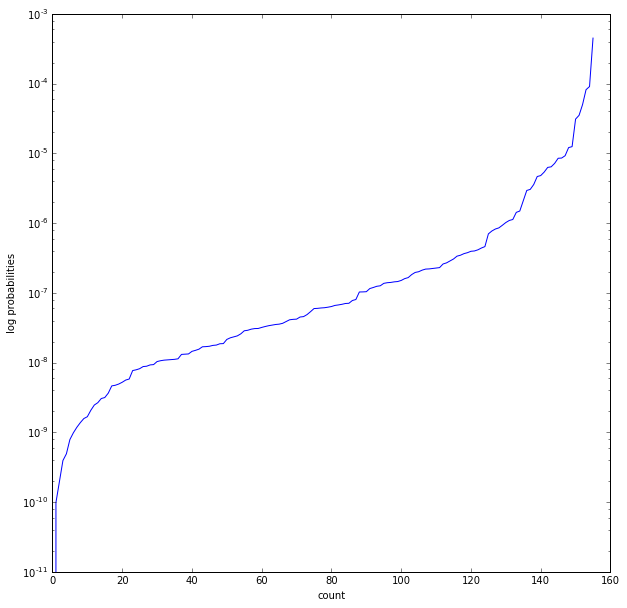

In [35]:
plt.figure(figsize=(10,10))
plt.yscale('log')
plt.xlabel('count')
plt.ylabel('log probabilities')
plt.plot(np.sort(final_result['probability'].unique()))

# Probability Density Calculation # Approach 2

Since, we wanted to compare the results of our above approach with another method of probability density calculation, we went forward to implement another way of visualizing this. 

We outlined an approach where instead of dividing the data into multiple bins using a threshold, we divided the data equally into 20 bins. This way the volume of the bin would become variable and would require to be calculated in the following manner :- 

<i>
  <br>flow_difference = prob_data.flow.max() - prob_data.flow.min()
  <br>occupancy_difference = prob_data.occupancy.max() - prob_data.occupancy.min()
  <br>speed_difference = prob_data.speed.max() - prob_data.speed.min()
</i>

<br><center><b><i> volume = flow_difference</i> x <i> occupancy_difference</i> x <i> speed_difference </i></b></center>
<br>So, here instead of a variable number of vectors_in_box, the probability density would depend upon the volume of the box.

probability = points_inside_box / float(total_points * volume)

In the below step we define a low and a high value which indicates equal vectors being placed in every bin.
Now, Calling the below code for  <i><b>flow</b></i> column with an initial <i><b>low and high</b></i> value of <i><b>0 and 20 respectively</b></i>. This signifies that with a flow column length of <i><b>1,00,00,000</b></i> we would divide the flow column into <i><b>20 bins</b></i> containing equal number of vectors in each bin. 

In [36]:
low = 0;
high1 = int(len(result)/20)
BinNum = 20;
length = high1 - low
flowBins = np.zeros(shape=(20,high1), dtype = object)
for i in range(0, 20, 1):
    high = low + high1
    flowBins[i] = [result[low : high]]
    low = high

Moving in a similar manner for <i><b>occupancy</b></i> column

In [37]:
import numpy as np
flow_occupancy_bin = np.ndarray(shape=(20,20), dtype = object)
y = 1;
low = 0;
for i in range(0,20,1):
    data = pd.DataFrame(flowBins[i].reshape((-1,length))[0][0]);
    data = data.sort_values(["occupancy"])
    high1 = int(len(flowBins[1])/20)
    low = 0
    for j in range(0, 20, 1):
        high = low + high1
        flow_occupancy_bin[i][j] = [data[low : high]]
        low = high

Finally concluding for  <i><b>speed</b></i> column....
<br>
<br> Calling below code for  <i><b>speed</b></i> column with a initial <i><b>high and low</b></i> value of <i><b>0 and 20</b></i>. This signifies that with a subset of the orginal dataset, contains equal number of flow vectors in each bin,  equal number of occupancy vectors in the each bin and we would further divide the first flow_occupancy_bin into <i><b>20</b></i> bins containing equal number of speed vectors in each.

In [38]:
import numpy as np
flow_occupancy_speed_bin = np.ndarray(shape=(20,20,20), dtype = object)
for i in range(0,20,1):
    for k in range(0,20,1):
        data = flow_occupancy_bin[i][k][0];
        data = data.sort_values(["speed"])
        low = 0;
        high1 = int(len(flow_occupancy_bin[0][0][0])/20)
        for j in range(0, 20, 1):
            high = low + high1
            flow_occupancy_speed_bin[i][k][j] = [data[low : high]]
            low = high

# Iterating and Calculating probability densities

Similar to the idea outlined in #1 approach, here also we utilize the capability of IPython notebook to run command line directly. We iterate over the 20 bins of flow, 20 bins of occupancy and 20 bins of speed. Internally we calculate the volume and utilize the formula used in approach #1 to compute the probability distribution i.e 
<br><br><center><b><i> probability = points_inside_box / float(total_points * volume) </i></b></center>

In [39]:
!mkdir output

In [40]:
vectors = len(result)
for i in range(1,20,1):
    for j in range(1,20,1):
        for k in range(1,20,1):
            prob_data = flow_occupancy_speed_bin[i][j][k][0]
            currVectors = flow_occupancy_speed_bin[i][j][k][0].shape[0]
            flow_difference = prob_data.flow.max() - prob_data.flow.min()
            occupancy_difference = prob_data.occupancy.max() - prob_data.occupancy.min()
            speed_difference = prob_data.speed.max() - prob_data.speed.min()
            volume = flow_difference * occupancy_difference * speed_difference
            if(volume == 0): volume =1
            probability = currVectors/float(vectors * volume)
            prob_data["probability"] = probability
            prob_data.to_csv("output/out" + str(i) + '-' + str(j) + '-' + str(k) + ".csv",sep="\t")  

/Users/abhisheknigam/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [41]:
! cat output/*.csv > merged-1.csv

In [42]:
!rm -rf output/

# Loading merged.csv and analyzing probability densities

In [43]:
merged = pd.read_csv("merged-1.csv", na_values=['-'], delimiter="\t", error_bad_lines=False)

Cleaning unnecessary headers appended due to merge operation using terminal

In [44]:
removeHeader = merged[merged["probability"] == "probability"]
merged = pd.concat([merged,removeHeader,removeHeader]).drop_duplicates(keep=False)

Analyzing merged dataframe

In [45]:
merged.tail()

,Unnamed: 0,detector,flow,occupancy,speed,timestamp,probability
7448868,1498145.0,y,29,4.0,62.0,2009-12-28T09:22:13,0.00012491335215514675
7448869,1563666.0,x,5,4.0,62.0,2010-03-12T00:24:09,0.00012491335215514675
7448870,1457989.0,x,11,4.0,62.0,2009-11-30T10:07:38,0.00012491335215514675
7448871,1548386.0,y,9,4.0,62.0,2010-02-03T19:33:46,0.00012491335215514675
7448872,1531388.0,y,11,4.0,62.0,2010-01-22T23:05:32,0.00012491335215514675


<h3> Assigning a probability density of zero to Known Bad Data</h3> 

In [46]:
removeResult1["probability"] = 0
removeResult2["probability"] = 0
removeResult3["probability"] = 0
#removeResult4["probability"] = 0
removeResult5["probability"] = 0
removeResult6["probability"] = 0

<h3>Merging bad data back into our "merged" dataset.</h3>

We append all the bad data with a probability density of zero into our "merged" dataset.

In [47]:
merged = merged.append(removeResult1);
merged = merged.append(removeResult2);
merged = merged.append(removeResult3);
#merged = merged.append(removeResult4);
merged = merged.append(removeResult5);
merged = merged.append(removeResult6);

<h3> Sorting the merged dataset based on probability.</h3> 
<br>
<b>We faced a challenge while sorting as probability column contained values with string datatype</b>. <i>So, we first converted the column to numberic and then we wrote the sorted result back to text file.</i> 

In [48]:
merged["probability"] = merged["probability"].apply(pd.to_numeric)
merged = merged.sort_values(["probability"])

<br> <b>Here we are sampling the data before writing the output. The sampling is done on every 100th row of the merged dataset.</b>

In [49]:
final_columns = ['flow', 'speed', 'occupancy', 'probability']
merged = merged[final_columns]
final_result = pd.DataFrame(columns = ["flow","speed","occupancy", "probability"])

for i in range(0,len(merged),100):
    final_result = final_result.append(merged.iloc[[i]])
final_result.to_csv("1160-1.txt",sep="\t")

# Probability Density visualization over unique values

The below cell brings up a graph which plots the range of probability densities. It can be seen easily that the densities range from 10^-3 to 10^-8. This is a significant change in densities and gives us information obout outliers at both ends. 

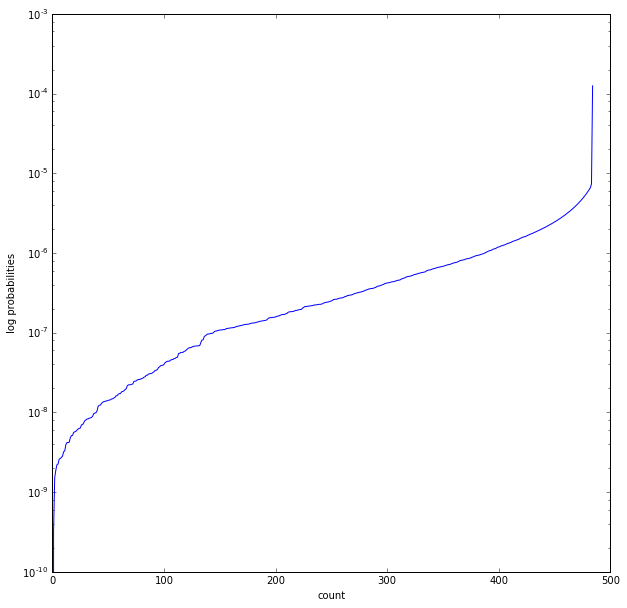

In [50]:
plt.figure(figsize=(10,10))
plt.yscale('log')
plt.xlabel('count')
plt.ylabel('log probabilities')
plt.plot(np.sort(final_result['probability'].unique()))

# Comparison of the two approaches

<i>If we compare the two approaches, we see that with the #1 approach, we get a much smoother graph with better density distribution towards the ends. In the #2 approach, the lowest and highest densities are concetrated to a higher degree towards the ends, which means that the distribution of densities is more extreme when compared with the #1 approach. </i>. 

<br><b>Other significant differences</b><br><br>

<b>#1 Approach</b> has unequal amount of data in each bin. This way we may end up having most of the data concentrated in some bins and other bins having significantly very less data. This may lead to :- 
<br><br>a) This may also result in some bins being empty.
<br><br>b) Best feature of this approach is that it would isolate the possible outliers in the data therefore giving a better probability distribution as compared to approach 
<br><br><br><br>
<b>#2 Approach</b> has equal amount of data in each bin. This way the data is equally distributed over all the bins. But with this approach we may end up classifying some good data with the outliers which can practically result in either of the two cases :-
<br><br>a) Good data with a small number of possible outliers increases the probability distribution of the entire bin inturn making it difficult to identify the outliers.
<br><br>b) Good data with a large number of possible outliers decreases the probability distribution of the entire bin inturn making the good data to be treated as an outlier.

# Probability Density Calculation using K-Mean Clustering # Approach 3